************************************
Summary Statistics Per Continent
   Cumulative Total Cases Per Continent as of March 9, 2023
   Total Population Per Continent

***************Results**************

Africa
    Total Cases: 12,097,198
    Populaion: 1,295,290,295
Asia
    Total Cases: 208,286,326
    Populaion: 4,544,009,064
Europe
    Total Cases: 247,755,428
    Populaion: 743,618,204
North America
    Total Cases: 122,332,851
    Populaion: 580,506,117
Oceania
    Total Cases: 13,787,886
    Populaion: 40,917,074
South America
    Total Cases: 67,961,748
    Populaion: 427,063,263
************************************

Trend of Cumulative Total Cases Per Continent from January 22, 2020 to March 9, 2023:


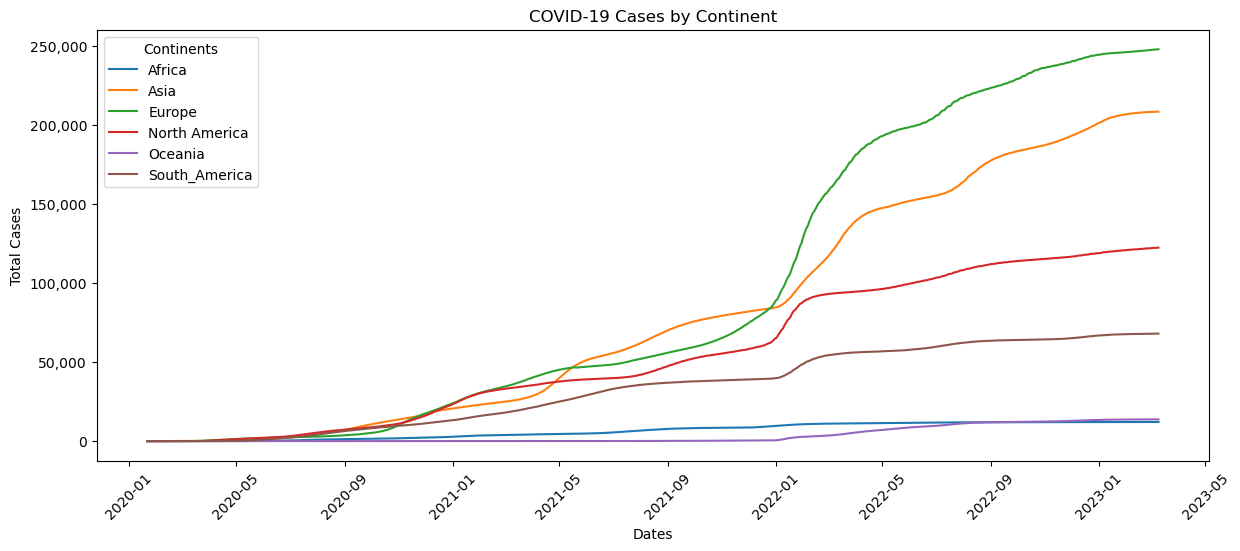

World Choropleth Map 
Cumulative Total Cases Per Country - Last Reported March 9, 2023:


In [4]:
# Run cell to import libraries, ignore FutureWarnings, and load data sets 
import geopandas as gpd 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily 
import mapclassify 
import folium
import aiohttp
import fsspec
import warnings

warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning
# Data sets 
url = "https://raw.githubusercontent.com/babdelfa/gis/main/covid_global.csv"
df = pd.read_csv(url)
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
pd.set_option('display.float_format', '{:,.2f}'.format)

# Include your final below (in this cell only):

"""[User Defined Functions]"""
#Creates Summary Stats of Total Cases and Population Per Continent on March 9th 2023
def Summary(gdf):
    print("************************************")
    print("Summary Statistics Per Continent")
    print("   Cumulative Total Cases Per Continent as of March 9, 2023")
    print("   Total Population Per Continent")

    print("\n***************Results**************\n")

    for col in gdf:
        if col == 'Continent':
            for continent in np.sort(a=gdf[col].unique()):
                print(continent)
                gdf_continent = gdf[gdf[col]== continent]
                print("    Total Cases:",f'{gdf_continent["Total Cases"].sum():,.0f}')
                print("    Populaion:",f'{gdf_continent["Population"].sum():,.0f}')
    print("************************************\n")
    
# Formats GDF Columns to Have Commas                
def format_with_commas(number):
    return '{:,.0f}'.format(number)  

"""[Preliminary Work]"""
# Melt Data From Wide to Long and Change Variable Type to Date [OUTPUT 1, 2 & 3]
df_melted = pd.melt(df, id_vars=["iso_a3"], var_name="dates", value_name="cases")
df_melted.dates = pd.to_datetime(df_melted["dates"], format = 'mixed' )

# Preserve Copy of GDF With Time Series Data For Chart Later [OUTPUT 1]
gdf_merged = pd.merge(gdf, df_melted , left_on = "iso_a3", right_on = "iso_a3")              

# Subset the melted data for March 9th only and drop the dates column [OUTPUT 2 & 3]
df_melted = df_melted.loc[(df_melted["dates"] == "2023-03-09")]
df_melted.drop(columns = ['dates'], inplace = True)

# Merge the df and gdf through iso_3 with no dates for Interactive Map [OUTPUT 2 & 3]
gdf_current = pd.merge(gdf, df_melted , left_on = "iso_a3", right_on = "iso_a3")

# Drop unneeded columns->rename and sort the rest [OUTPUT 2 & 3]
gdf_current.drop(columns = ['iso_a3'], inplace = True)
gdf_current.rename(columns = {'name':"Name", 'continent':"Continent",'pop_est':"Population",'cases':"Total Cases"}, inplace = True )
gdf_current= gdf_current[['Name','Total Cases','Population','Continent','geometry']].copy()

"""[OUTPUT 1]"""
# Display Summary Stats
Summary(gdf_current)

"""[OUTPUT 2]"""
#Subset each continent retaining dates and total cases
continents = gdf_merged.groupby(["continent","dates"], as_index=False)['cases'].sum()
Africa = continents[continents['continent']== 'Africa']
Asia = continents[continents['continent']== 'Asia']
Europe = continents[continents['continent']== 'Europe']
North_America = continents[continents['continent']== 'North America']
Oceania = continents[continents['continent']== 'Oceania']
South_America = continents[continents['continent']== 'South America']

#Add each continent to the plot and adjust fig size
fg, ax = plt.subplots(figsize = (12,5))
plt.plot(Africa.dates, Africa.cases, label ="Africa")
plt.plot(Asia.dates, Asia.cases, label ="Asia")
plt.plot(Europe.dates, Europe.cases, label ="Europe")
plt.plot(North_America.dates, North_America.cases, label ="North America")
plt.plot(Oceania.dates, Oceania.cases, label ="Oceania")
plt.plot(South_America.dates, South_America.cases, label ="South_America")

#Adjust layout of the graph
locs, labels = plt.yticks()
locs = locs[1:locs.size-1]
plt.tight_layout()
plt.title("COVID-19 Cases by Continent")
plt.yticks( ticks = locs , labels = ['0','50,000', '100,000','150,000','200,000','250,000'] , minor=False)
plt.ylabel("Total Cases")
plt.xlabel("Dates")
plt.xticks(rotation = 45)
plt.legend(title = "Continents")
print("Trend of Cumulative Total Cases Per Continent from January 22, 2020 to March 9, 2023:")
plt.show()

"""[OUTPUT 3]"""
# Series of Total Cases as Integers For Correct Color Mapping
total_cases_int = gdf_current['Total Cases']        

# Generate commas for Population and Total Cases For Interactive Map Lables
gdf_current['Total Cases'] = gdf_current['Total Cases'].apply(lambda x: format_with_commas(x))
gdf_current['Population'] = gdf_current['Population'].apply(lambda x: format_with_commas(x))

#Interactive Map of aggregate Cases and Population by Country on the 9th of March 2023
print("World Choropleth Map \nCumulative Total Cases Per Country - Last Reported March 9, 2023:")
gdf_current.explore(column = total_cases_int, cmap="Reds", legend = False, scheme = 'quantiles',  fmt = "{:,.2f}" )